# Top Molecules identified by each SBVS Method

This notebook allows to visualize the **top $k$ molecules identified by each SBVS method**, i.e., the two machine learning models and the three consensus strategies.

<div class="alert alert-warning">
The ranking was computed from the $30 \times 4 cv$ results.
</div>

- $30 \times 4 cv$ results were computed in [this notebook](./2_30x4CV_analysis.ipynb). 
- See the cells below for a more detailed description about these results and how they were generated to **obtain a single molecular ranking**.

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdDepictor
import matplotlib.pyplot as plt

In [27]:
protein_name = 'cdk2'

## Load the datasets
### Load the ensemble docking results

In [28]:
# Load the dataset
file_name = '../4_Ensemble_docking_results/' + \
            'df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
df_dk_res = pd.read_pickle(file_name)

# Extract the features columns: Docking scores
X = df_dk_res.drop('activity', axis = 1)
# Extract the response variable: Activity
y = df_dk_res['activity']

### Load the molecules saved as `rdkit` objects

In [29]:
# Load the dataframe with the rdkit molecules (no duplicates)
rdk_mols_file = '../2_Molecular_libraries/df_MOLECULES_no_duplicates.obj'
df_rdk_mols = pd.read_pickle(rdk_mols_file)
df_rdk_mols = df_rdk_mols.replace({'DEKOIS2': 'DEKOIS'})
df_rdk_mols = df_rdk_mols.set_index(['library', 'Lig'])

In [30]:
# Verify that both datasets match
assert np.all(X.index == df_rdk_mols.index)

## Load the `30x4cv` results
- This analysis was performed in the `2_30x4CV_analysis.ipynb` notebook.
- It contains the performance of the SBVS methods (ML and consensus strategies) of the 30x4cv analysis
- It also includes the information of each of the $120 \times 4$ validation sets:
    - The indices of the molecules used at each validation set.
    - The predictions of each of the SBVS methods:
        - The probabilities (*logits*) of the ML methods
        - The aggregation value determined by the consensus strategy.
        
- Results from other $30 \times 4 cv$ analysis can also be explored using this notebook, just change the `evaluation_name` variable:

```python
# Example
evaluation_name = f'{n_repeats}x{n_splits}cv_DEFAULT_HYPRMS_hsp90'
```
- See the available $30 \times 4 cv$ results inside the `./cachedir` directory.

In [31]:
n_repeats = 30
n_splits  = 4
evaluation_name = f'{n_repeats}x{n_splits}cv'
filename = f'./cachedir/{evaluation_name}_{protein_name}'
cv30x4, y_preds, splits = joblib.load(filename)

#******************
#      NOTES
#******************

# cv30x4:  Are the results, per metric and per method, of the 30x4cv 

# y_preds: Is a dictionary where the key corresponds to the method's name
#          and the value is a list with the 120 predictions of the method
#          over the validation set. Each element of the list, is a numpy array
#.         with the predicions of the 25% of the molecules used for that
#          validation set. For the ML models, the values are the probabilities
#          returned by the classifier. For the Consensus scorings, the values
#.         are those resulting from the aggregation method applied over the raw
#          docking scores.

# splits:  is a list of 120 elements, where each element is a tuple where 
#          the second element is anumpy array with
#.         the indices of the molecules used for the validation sets.

# Therefore, each array inside y_preds contains the predictions of the method.

### Determine the rankings of each SBVS method after `30x4cv` analysis

In [32]:
def combine_cv_results(set_preds, k):
    '''
    Take `set_preds` which is a list of nxk elements,
    where each element is an array containing
    the indices of the samples comprising each validation
    set. 
    
    Returns a list of size 
    '''
    assert len(set_preds) % k == 0
    chunks = []
    for i in range(0, len(set_preds), k):
        chunks.append( set_preds[i: i+k])
    return chunks

In [33]:
# Number of validations sets = 120
n_val_sets   = n_repeats * n_splits
# Get only the validation sets
val_sets_ids = [i[1] for i in splits]

# List of results per method
m_preds_ranks = {}

for m_name in y_preds.keys():
    # Just get the validation set indices from the tuples
    # insidet the `splits` list
    set_preds = [
        pd.DataFrame(y_preds[m_name][i], 
                     index=val_set).rank(ascending=False)
         for i, val_set in enumerate(val_sets_ids)
    ]

    # Every k elements belong to 1 repeat of CV,
    # therefore, we can get the predictions per repeat
    # of all molecules using the `every_k_
    chunks = combine_cv_results(set_preds, k=n_splits)

    final_ranks = pd.concat([pd.concat(chunk, axis=0) 
                             for chunk in chunks], 
                            axis   = 1,
                            levels = None,
                            keys = range(1, n_repeats + 1))
    final_ranks.columns = final_ranks.columns.droplevel(1)
    final_ranks.columns.name = 'Repeats'
    final_ranks.index.name   = 'Molecules'

    # Add the labels: the y_true values
    mean_ranks = final_ranks.mean(axis = 1).to_frame(name='mean_rank')
    # Add the dataframe to the dictionary `m_preds_ranks`
    m_preds_ranks[m_name] = mean_ranks
# Convert the dictionary to a DataFrame
df_rank_preds = pd.concat(m_preds_ranks.values(), 
                          axis = 1, 
                          keys = y_preds.keys())
# For a better visualization of the table, let's format it
df_rank_preds.columns = df_rank_preds.columns.droplevel(1)
df_rank_preds = df_rank_preds.rank().astype('int')
Activities_list = ['Active' if i else 'Inactive' for i in y.values]
df_rank_preds.insert(loc = 0, column = 'Activity', value = Activities_list)
df_rank_preds.index = y.index
df_rank_preds.index.names = ['Library', 'Lig. Name']
df_rank_preds.columns.names = ['Ranking']
# Update the name of the columns
df_rank_preds = df_rank_preds.rename(columns = {'ml_lr'  : 'LR',
                      'ml_xgb' : 'GBT',
                      'ml_dclf': 'Dcfl',
                      'cs_MEAN': 'csAVG',
                      'cs_GEOM': 'csGEOM',
                      'cs_MIN' : 'csMIN'})

## Correlations between ranks

In [34]:
methods = ['LR','GBT','csAVG','csGEOM','csMIN']
# Correlation over the full set
df_corr = df_rank_preds[methods].corr(method = 'kendall').round(3)
df_corr

Ranking,LR,GBT,csAVG,csGEOM,csMIN
Ranking,,,,,
LR,1.000,0.534,0.230,0.231,0.122
GBT,0.534,1.000,0.267,0.265,0.169
csAVG,0.230,0.267,1.000,0.991,0.694
csGEOM,0.231,0.265,0.991,1.000,0.690
csMIN,0.122,0.169,0.694,0.690,1.000


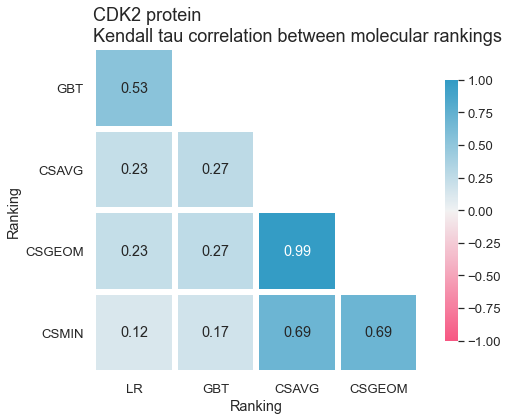

In [43]:
sns.set(style='whitegrid', font_scale = 1.2)
fig, ax = plt.subplots(figsize=(9, 6))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
# title
title = f'{protein_name.upper()} protein\n' +\
        'Kendall tau correlation between molecular rankings'
plt.title(title, loc='left', fontsize=18)
plt.savefig(f'{protein_name}_rankings.pdf')
plt.show()

## Draw the  top $k$ molecules of each SBVS method

In [36]:
# Define a function to draw the top molecules

def draw_top_mols_by_method(method, n_mols=9, 
                            subImgSize = (300, 220),
                            alignSubstructure = False):
    '''
    `df_rank_preds` and `df_rdk_mols` should be created. 
    '''
    # Get the top molecules by the given method
    df_top_mols_by_method = df_rank_preds.sort_values(method).head(n_mols)
    # Drop the Dummy classifier for simplicity
    df_top_mols_by_method = df_top_mols_by_method.drop('Dcfl', axis = 1)
    idx = (df_top_mols_by_method).index
    mols_rows = df_rdk_mols.loc[idx]
    # Verify the indices match
    assert np.all(df_top_mols_by_method.index == mols_rows.index)
    # Add extra data => MW, num atoms, num rot
    df_top_mols_by_method = pd.concat([df_top_mols_by_method, 
                                       mols_rows[['MW','num_atoms','num_rot']]], 
                                      axis = 1)
    # Get the mol objects
    mols = mols_rows['mol_rdk'].to_list()

    # Create the molecular labels
    mols_labels = [ f'{name} ({lib})' for lib, name
                    in mols_rows.index]
    mols_labels = [f'{ac} - {lb}' for ac, lb in 
                   zip(df_top_mols_by_method['Activity'], mols_labels)]
    # Convert to 2D for visualization
    for i in mols: AllChem.Compute2DCoords(i)

    # Get the common cores
    match_all = rdFMCS.FindMCS(mols, completeRingsOnly = False,
                               bondCompare=Chem.rdFMCS.BondCompare.CompareAny)
    # Convert to mol objects
    mcs_all = Chem.MolFromSmarts(match_all.smartsString)
    if alignSubstructure:
        # Aling molecules to the Maximum common substructure
        AllChem.Compute2DCoords(mcs_all)
        subms = [x for x in mols 
                     if x.HasSubstructMatch(
                      mcs_all
                     )]
        for m in mols:
            _ = AllChem\
            .GenerateDepictionMatching2DStructure(m, mcs_all)

    # Draw the molecules
    rdDepictor.SetPreferCoordGen(False)
    img = Chem.Draw.MolsToGridImage(
         mols,
         molsPerRow = 3,
         legends = mols_labels,
         useSVG=True,
         highlightAtomLists=[ mol.GetSubstructMatch(mcs_all) for mol in mols], 
         subImgSize = subImgSize)
    return img, df_top_mols_by_method

### Logistic Regression

Activity  LR  GBT  csAVG  csGEOM  csMIN       MW  num_atoms  \
Library Lig. Name                                                               
COCRYS  I19         Active   1   32    197     200    546  452.558         33   
DUD     ligand_61   Active   2    5    495     515   1374  304.309         23   
COCRYS  D31         Active   3   65     65      68    387  423.561         31   
CSAR    CS13        Active   4    2    588     588   1098  316.817         21   
        CS14        Active   5    8    410     413   1186  300.362         21   
DUD     ligand_63   Active   6   15    540     566   1443  310.338         22   
COCRYS  371         Active   7   62    118     137    326  403.412         28   
        3I6         Active   8  248   1006     990   2357  402.274         23   
DUD     ligand_6    Active   9   11    186     199    763  334.335         25   

                   num_rot  
Library Lig. Name           
COCRYS  I19              6  
DUD     ligand_61        2  
COCRYS  D31              5  
CSAR    CS13             3  
        CS14             3  
DUD     ligand_63        2  
COCRYS  371              2  
        3I6              6  
DUD     ligand_6         3

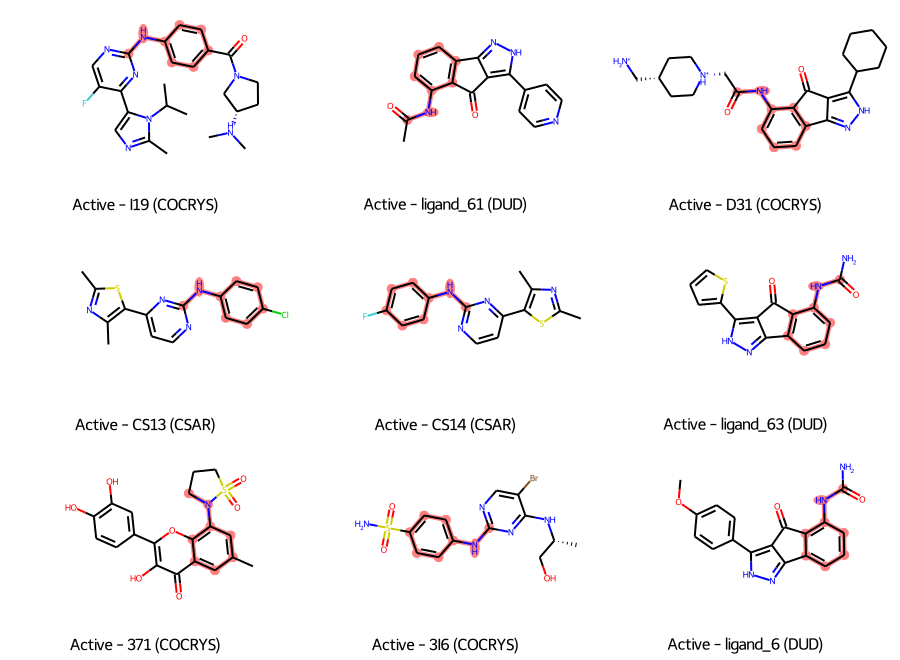

In [37]:
# Define the method
method = 'LR'
n_mols = 9

img, df_top = draw_top_mols_by_method(method, n_mols=n_mols)

display(df_top)
display(img)

### Gradient Boosting Trees

Activity   LR  GBT  csAVG  csGEOM  csMIN       MW  \
Library Lig. Name                                                     
COCRYS  03Z         Active  135    1    113     112    236  374.447   
CSAR    CS13        Active    4    2    588     588   1098  316.817   
COCRYS  FRV         Active   36    3    103     105    400  384.465   
        04Z         Active  193    4     95      93    232  406.489   
DUD     ligand_61   Active    2    5    495     515   1374  304.309   
COCRYS  X40         Active   99    6    106     106    335  375.435   
        CDK         Active   10    7    204     207    419  435.531   
CSAR    CS14        Active    5    8    410     413   1186  300.362   
COCRYS  26Z         Active   47    9     36      35     96  389.462   

                   num_atoms  num_rot  
Library Lig. Name                      
COCRYS  03Z               25        5  
CSAR    CS13              21        3  
COCRYS  FRV               27        6  
        04Z               27        6  
DUD     ligand_61         23        2  
COCRYS  X40               25        5  
        CDK               29        8  
CSAR    CS14              21        3  
COCRYS  26Z               26        5

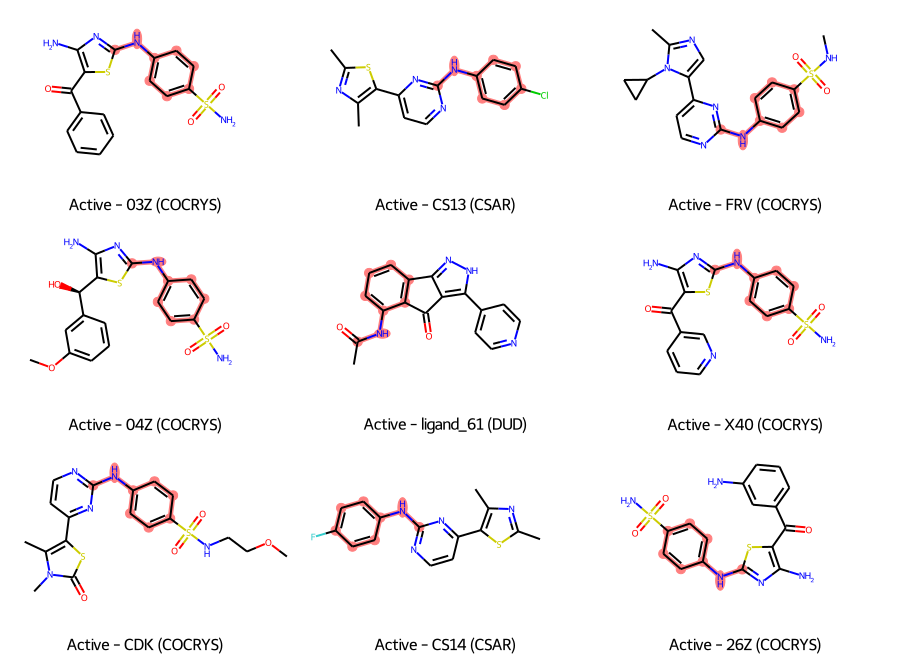

\begin{tabular}{lllrrrrrrrr}
\toprule
       &     & Activity &   LR &  GBT &  csAVG &  csGEOM &  csMIN &     MW &  num\_atoms &  num\_rot \\
Library & Lig. Name &          &      &      &        &         &        &        &            &          \\
\midrule
COCRYS & 03Z &   Active &  135 &    1 &    113 &     112 &    236 &  374.4 &         25 &        5 \\
CSAR & CS13 &   Active &    4 &    2 &    588 &     588 &   1098 &  316.8 &         21 &        3 \\
COCRYS & FRV &   Active &   36 &    3 &    103 &     105 &    400 &  384.5 &         27 &        6 \\
       & 04Z &   Active &  193 &    4 &     95 &      93 &    232 &  406.5 &         27 &        6 \\
DUD & ligand\_61 &   Active &    2 &    5 &    495 &     515 &   1374 &  304.3 &         23 &        2 \\
COCRYS & X40 &   Active &   99 &    6 &    106 &     106 &    335 &  375.4 &         25 &        5 \\
       & CDK &   Active &   10 &    7 &    204 &     207 &    419 &  435.5 &         29 &        8 \\
CSAR & CS14 &   Active 

In [38]:
# Define the method
method = 'GBT'
n_mols = 9

img, df_top = draw_top_mols_by_method(method, n_mols=n_mols)

display(df_top)
display(img)

# Save for supplementary material
filename = f'{protein_name}_{n_mols}_topMols_{method}.svg'
with open(filename, 'w') as f:
    f.write(img.data)
    
print(df_top.round(1).to_latex())

### Average Consensus strategy (csAVG)

Activity    LR  GBT  csAVG  csGEOM  csMIN       MW  \
Library Lig. Name                                                        
COCRYS  72L           Active   215  316      1       1     17  442.504   
DEKOIS  decoy_103   Inactive   164  140      2       2     13  399.410   
        decoy_1191  Inactive  1537  178      3       3      2  484.531   
        decoy_1063  Inactive  2273  139      4       4      6  434.519   
DUD     ligand_68     Active   159  203      5       6     90  449.517   
COCRYS  3FP           Active   162  226      6       5     57  466.459   
CSAR    CS247       Inactive   257  123      7       7     93  509.544   
COCRYS  20Z           Active   587  133      7       7     11  424.507   
DEKOIS  decoy_114   Inactive  2029  312      9       9     28  388.379   

                    num_atoms  num_rot  
Library Lig. Name                       
COCRYS  72L                32        5  
DEKOIS  decoy_103          30        5  
        decoy_1191         36        7  
        decoy_1063         33        6  
DUD     ligand_68          31        5  
COCRYS  3FP                33        9  
CSAR    CS247              36        8  
COCRYS  20Z                29        5  
DEKOIS  decoy_114          29        4

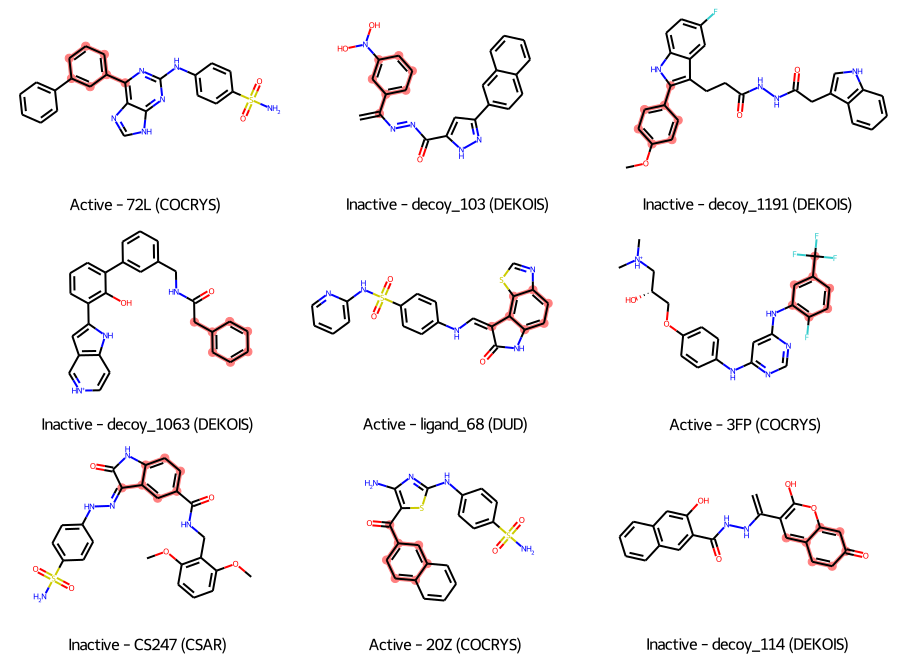

\begin{tabular}{lllrrrrrrrr}
\toprule
       &           &  Activity &    LR &  GBT &  csAVG &  csGEOM &  csMIN &     MW &  num\_atoms &  num\_rot \\
Library & Lig. Name &           &       &      &        &         &        &        &            &          \\
\midrule
COCRYS & 72L &    Active &   215 &  316 &      1 &       1 &     17 &  442.5 &         32 &        5 \\
DEKOIS & decoy\_103 &  Inactive &   164 &  140 &      2 &       2 &     13 &  399.4 &         30 &        5 \\
       & decoy\_1191 &  Inactive &  1537 &  178 &      3 &       3 &      2 &  484.5 &         36 &        7 \\
       & decoy\_1063 &  Inactive &  2273 &  139 &      4 &       4 &      6 &  434.5 &         33 &        6 \\
DUD & ligand\_68 &    Active &   159 &  203 &      5 &       6 &     90 &  449.5 &         31 &        5 \\
COCRYS & 3FP &    Active &   162 &  226 &      6 &       5 &     57 &  466.5 &         33 &        9 \\
CSAR & CS247 &  Inactive &   257 &  123 &      7 &       7 &     93 &  509.5 & 

In [39]:
# Define the method
method = 'csAVG'
n_mols = 9

img, df_top = draw_top_mols_by_method(method, n_mols=n_mols)

display(df_top)
display(img)

# Save for supplementary material
filename = f'{protein_name}_{n_mols}_topMols_{method}.svg'
with open(filename, 'w') as f:
    f.write(img.data)
    
print(df_top.round(1).to_latex())

### Min Consensus strategy (csMIN)

Activity    LR  GBT  csAVG  csGEOM  csMIN       MW  \
Library Lig. Name                                                        
COCRYS  LQ5           Active   232  247    209     208      1  503.529   
DEKOIS  decoy_1191  Inactive  1537  178      3       3      2  484.531   
COCRYS  2KD           Active  1376  487     21      22      3  503.918   
DEKOIS  decoy_722   Inactive  2649  378     15      15      4  543.475   
CSAR    CS112       Inactive  3131  357     82      89      5  421.429   
DEKOIS  decoy_1063  Inactive  2273  139      4       4      6  434.519   
COCRYS  EZR           Active   101  117     67      67      7  454.558   
DEKOIS  decoy_755   Inactive   515  265     42      41      8  393.355   
        decoy_1175  Inactive  2222  342     15      16      8  504.626   

                    num_atoms  num_rot  
Library Lig. Name                       
COCRYS  LQ5                36        6  
DEKOIS  decoy_1191         36        7  
COCRYS  2KD                36        7  
DEKOIS  decoy_722          37        9  
CSAR    CS112              31        8  
DEKOIS  decoy_1063         33        6  
COCRYS  EZR                34        4  
DEKOIS  decoy_755          29        4  
        decoy_1175         37        8

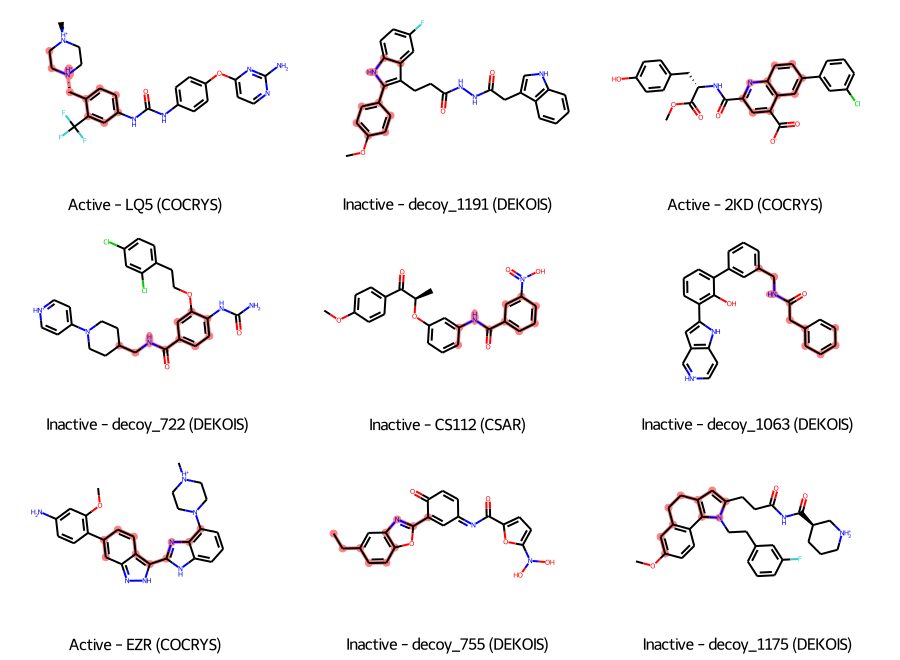

\begin{tabular}{lllrrrrrrrr}
\toprule
       &            &  Activity &    LR &  GBT &  csAVG &  csGEOM &  csMIN &     MW &  num\_atoms &  num\_rot \\
Library & Lig. Name &           &       &      &        &         &        &        &            &          \\
\midrule
COCRYS & LQ5 &    Active &   232 &  247 &    209 &     208 &      1 &  503.5 &         36 &        6 \\
DEKOIS & decoy\_1191 &  Inactive &  1537 &  178 &      3 &       3 &      2 &  484.5 &         36 &        7 \\
COCRYS & 2KD &    Active &  1376 &  487 &     21 &      22 &      3 &  503.9 &         36 &        7 \\
DEKOIS & decoy\_722 &  Inactive &  2649 &  378 &     15 &      15 &      4 &  543.5 &         37 &        9 \\
CSAR & CS112 &  Inactive &  3131 &  357 &     82 &      89 &      5 &  421.4 &         31 &        8 \\
DEKOIS & decoy\_1063 &  Inactive &  2273 &  139 &      4 &       4 &      6 &  434.5 &         33 &        6 \\
COCRYS & EZR &    Active &   101 &  117 &     67 &      67 &      7 &  454.6 &    

In [40]:
# Define the method
method = 'csMIN'
n_mols = 9

img, df_top = draw_top_mols_by_method(method, n_mols=n_mols)

display(df_top)
display(img)


# Save for supplementary material
filename = f'{protein_name}_{n_mols}_topMols_{method}.svg'
with open(filename, 'w') as f:
    f.write(img.data)
    
print(df_top.round(1).to_latex())